# Load Library

In [ ]:
pip install vncorenlp

     |████████████████████████████████| 2.6 MB 2.1 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=31a8c415c669c9c706b050acc6d8b87923767cb8b3a71994a766b4ca2124950f
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2021-12-22 12:33:27--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  66.2MB/s    in 0.4s    

2021-12-22 12:33:29 (66.2 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-12-22 12:33:29--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

In [ ]:
from vncorenlp import VnCoreNLP

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
pip install pyvi

     |████████████████████████████████| 8.5 MB 2.0 MB/s 
     |████████████████████████████████| 743 kB 25.5 MB/s 


In [ ]:
### Import ###
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
import numpy as np 
import re
import pickle
import seaborn as sn
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam # - Works
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Prepare DATA

##Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/hmtk_th_dataset/hate_speech/train.csv', index_col=False)
test = pd.read_csv('/content/drive/MyDrive/hmtk_th_dataset/hate_speech/test.csv', index_col=False)
dev = pd.read_csv('/content/drive/MyDrive/hmtk_th_dataset/hate_speech/dev.csv', index_col=False)

train.reset_index(drop=True)
print('Train \n')
print(train.head(10))
print('\n\nDev \n')
print(dev.head(10))
print('\n\nTest \n')
print(test.head(10))
len(train.index) + len(test.index) + len(dev.index)

Train 

                                           free_text  label_id
0  Em được làm fan cứng luôn rồi nè ❤️ reaction q...         0
1  Đúng là bọn mắt híp lò xo thụt :))) bên việt n...         2
2           Đậu Văn Cường giờ giống thằng sida hơn à         0
3  CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...         2
4  Từ lý thuyết đến thực hành là cả 1 câu chuyện ...         0
5                             Coronavirus is manmade         0
6                              Đố chúng m nhận ra ai         0
7                                  Lúp lúp như chó .         1
8                                                🥰🥰🥰         0
9  Thế mà mình nói mấy thằng bắc kì, bọn đó lại b...         2


Dev 

                                           free_text  label_id
0                                       Coi cười xỉu         0
1                    Chi ba vang ngoc dep va tre mai         0
2  Chần vần một đống, không ai đoán trước được đừ...         0
3                              Du học s

33400

In [ ]:
all=0
print('\nTrain')
value_count=train['label_id'].value_counts()
all+=value_count
print(value_count)

print('\nDev')
value_count=dev['label_id'].value_counts()
all+=value_count
print(value_count)

print('\nTest')
value_count=test['label_id'].value_counts()
all+=value_count
print(value_count)

print('\nAll')
print(all)


Train
0    19886
2     2556
1     1606
Name: label_id, dtype: int64

Dev
0    2190
2     270
1     212
Name: label_id, dtype: int64

Test
0    5548
2     688
1     444
Name: label_id, dtype: int64

All
0    27624
2     3514
1     2262
Name: label_id, dtype: int64


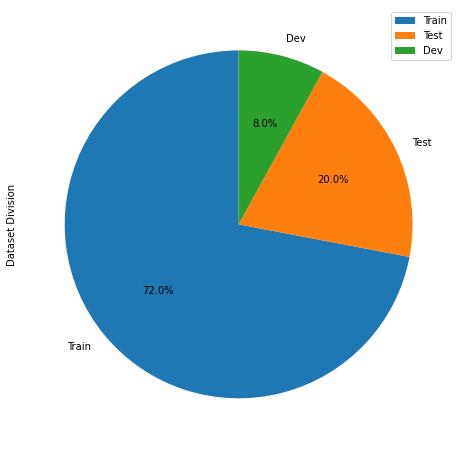

In [ ]:
data = {len(train.index),len(test.index),len(dev.index)}
df = pd.DataFrame(data,columns=['Dataset Division'],index = ['Train','Test','Dev'])

df.plot.pie(y='Dataset Division',figsize=(8, 8),autopct='%1.1f%%', startangle=90)
plt.show()

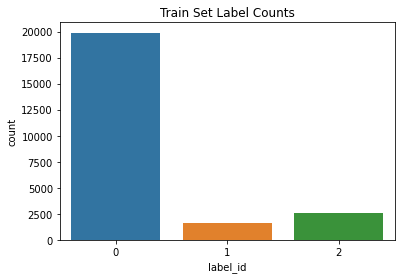

In [ ]:
fig_train = sns.countplot(x= 'label_id',data = train)
plt.title('Train Set Label Counts')
plot_train = fig_train.get_figure()

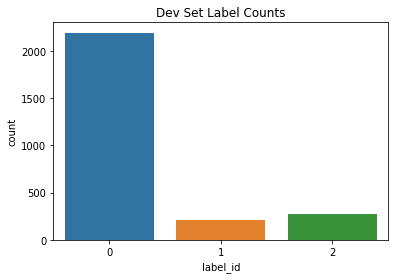

In [ ]:
fig_train = sns.countplot(x= 'label_id',data = dev)
plt.title('Dev Set Label Counts')
plot_train = fig_train.get_figure()

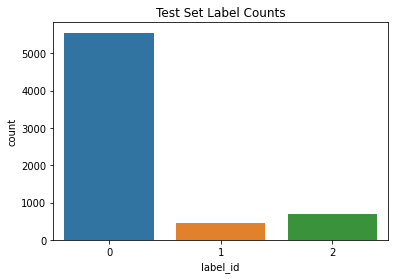

In [ ]:
fig_test = sns.countplot(x= 'label_id',data = test)
plt.title('Test Set Label Counts')
plot_test = fig_test.get_figure()

##Pre-process

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

STOPWORDS = '/content/drive/MyDrive/hmtk_th_dataset/hate_speech/vietnamese.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(regrex_pattern,'',text)

def preprocess(text, tokenized=True, lowercased=True, no_stw=True):
#    text = ViTokenizer.tokenize(text)
#    text = ' '.join(vncorenlp.tokenize(text)[0])
    if no_stw == True:
        text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'http\S+', '', text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text

def pre_process_features(X, y, tokenized=True, lowercased=True, no_stw=True):
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased, no_stw=no_stw) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx) 
    return X, y



X_train = train['free_text']
y_train = train['label_id'].values
X_temp = train['free_text']

#X_dev = dev['free_text']
#y_dev = dev['label_id'].values

X_test = test['free_text']
y_test = test['label_id'].values

In [ ]:
#X_train = [str(t) for t in X_train]
#X_test = [str(t) for t in X_test]


X_train, y_train = pre_process_features(X_train, y_train, tokenized=True, lowercased = True, no_stw=False)
#dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
X_test, y_test = pre_process_features(X_test, y_test, tokenized=True, lowercased = True, no_stw=False)


train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True, no_stw=True)
#dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True, no_stw=True)

In [ ]:
# So sánh trước và sau khi tiền xử lý.
list_of_tuples = list(zip(X_temp, train_X))
compare_list = pd.DataFrame(list_of_tuples, columns = ['Original', 'Pre-processed'])
compare_list

,Original,Pre-processed
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,fan cứng nè reaction cute coi mấy hợp _ lí
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,bọn mắt híp lò _ xo thụt việt _ nam t r bọn t ...
2,Đậu Văn Cường giờ giống thằng sida hơn à,đậu văn cường thằng sida
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,côn _ đồ cục _ súc vô _ nhân đề nghi vn nhà _ ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,lý _ thuyết thực _ hành câu _ chuyện
...,...,...
24043,Thả tim cho sự cống hiến của ngài,thả tim cống _ hiến ngài
24044,Thua !,thua
24045,Ở Việt Nam thì có khánh sky..hải ngoại có trần...,việt _ nam khánh skyhải ngoại trần danh _ hài ...
24046,"1:22 ai lớp du chu cờ moo, Duyên dáng quá cô ơi",lớp du chu cờ moo duyên _ dáng


In [ ]:
X_train[0:10]

['em được làm fan cứng luôn rồi nè reaction quá hay quá cute coi mấy giờ này quá hợp_lí',
 'đúng là bọn mắt híp lò_xo thụt bên việt_nam t cái này ra cách đây năm r và bọn t gọi là cái l',
 'đậu văn cường giờ giống thằng sida hơn à',
 'côn_đồ cục_súc vô_nhân tính đề nghi vn nhà_nước vn ban thưởng',
 'từ lý_thuyết đến thực_hành là cả câu_chuyện dài',
 'coronavirus is manmade',
 'đố chúng m nhận ra ai',
 'lúp lúp như chó',
 '',
 'thế_mà mình nói mấy thằng bắc kì bọn đó lại bâu vô nói mình phân biệtd']

In [ ]:
train_X[0:10]

['fan cứng nè reaction cute coi mấy hợp _ lí',
 'bọn mắt híp lò _ xo thụt việt _ nam t r bọn t gọi l',
 'đậu văn cường thằng sida',
 'côn _ đồ cục _ súc vô _ nhân đề nghi vn nhà _ nước vn ban thưởng',
 'lý _ thuyết thực _ hành câu _ chuyện',
 'coronavirus is manmade',
 'đố m',
 'lúp lúp chó',
 '',
 'thế _ mà mấy thằng bắc kì bọn bâu vô phân biệtd']

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

vectorizer_nsw = CountVectorizer()
vectorizer_nsw.fit(train_X)

CountVectorizer()

In [ ]:
## Encode but including stopwords

X_train_encoded = vectorizer.transform(X_train)
X_test_encoded = vectorizer.transform(X_test)

In [ ]:
## Encode but not including stopwords

X_train_nsw_encoded = vectorizer_nsw.transform(train_X)
X_test_nsw_encoded = vectorizer_nsw.transform(test_X)

# Model

## Including stopwords

### Naive Bayes



In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(X_train_encoded, y_train)

MultinomialNB()

In [ ]:
NB_y_pred = NB.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(y_test, NB_y_pred)))
print("Precision: ",str(precision_score(y_test, NB_y_pred, average='macro')))
print("Recall: " + str(recall_score(y_test, NB_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(y_test, NB_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(y_test, NB_y_pred, average='macro')))

cmNB = confusion_matrix(y_test, NB_y_pred)
crNB = classification_report(y_test, NB_y_pred)

Accuracy: 0.8600299401197605
Precision:  0.6761765108778222
Recall: 0.512328403964401
F1 - micro: 0.8600299401197605
F1 - macro: 0.5375741860455286


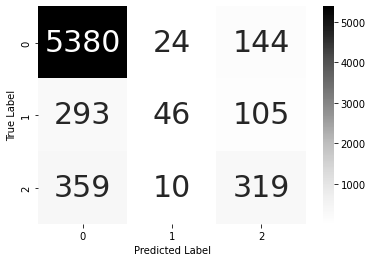

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmNB, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train_encoded, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
LR_y_pred=LR.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(y_test, LR_y_pred)))
print("Precision: ",str(precision_score(y_test, LR_y_pred, average='macro')))
print("Recall: " + str(recall_score(y_test, LR_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(y_test, LR_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(y_test, LR_y_pred, average='macro')))


cmLR = confusion_matrix(y_test, LR_y_pred)
crLR = classification_report(y_test, LR_y_pred)

Accuracy: 0.8676646706586826
Precision:  0.6971733658076186
Recall: 0.5536035230414935
F1 - micro: 0.8676646706586826
F1 - macro: 0.5995392937482261


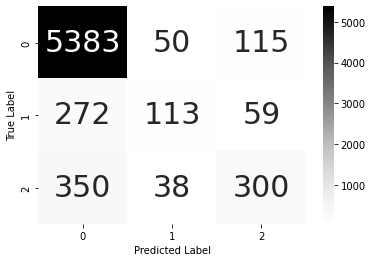

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmLR, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Decision Tree

In [ ]:
from sklearn import tree
DST = tree.DecisionTreeClassifier()
DST = DST.fit(X_train_encoded, y_train)

In [ ]:
DST_y_pred = DST.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(y_test, DST_y_pred)))
print("Precision: ",str(precision_score(y_test, DST_y_pred, average='macro')))
print("Recall: " + str(recall_score(y_test, DST_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(y_test, DST_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(y_test, DST_y_pred, average='macro')))

cmDST = confusion_matrix(y_test, DST_y_pred)
crDST = classification_report(y_test, DST_y_pred)

Accuracy: 0.8270958083832335
Precision:  0.5541560338648854
Recall: 0.5393672163469786
F1 - micro: 0.8270958083832335
F1 - macro: 0.5458037426855065


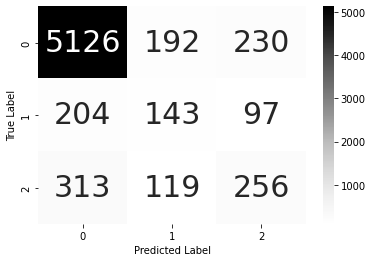

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmDST, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
pip install dtreeviz 


     |████████████████████████████████| 62 kB 423 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67936 sha256=0e9ed4641481668450615745d81f623f0f2d1be50746dba41d65c396e2a9177f
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz


In [ ]:
import graphviz
dot_data = tree.export_graphviz(DST, out_file=None, max_depth=15)
graph = graphviz.Source(dot_data)
graph.render("hate-speech-clf")

'hate-speech-clf.pdf'

### Support Vector Machine

In [ ]:
from sklearn import svm
SVM = svm.SVC(decision_function_shape='ovo')
SVM.fit(X_train_encoded, y_train) 

SVC(decision_function_shape='ovo')

In [ ]:
SVM_y_pred = SVM.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(y_test, SVM_y_pred)))
print("Precision: ",str(precision_score(y_test, SVM_y_pred, average='macro')))
print("Recall: " + str(recall_score(y_test, SVM_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(y_test, SVM_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(y_test, SVM_y_pred, average='macro')))

cmSVM = confusion_matrix(y_test, SVM_y_pred)
crSVM = classification_report(y_test, SVM_y_pred)

Accuracy: 0.8525449101796407
Precision:  0.7267305861248342
Recall: 0.43782243725759934
F1 - micro: 0.8525449101796407
F1 - macro: 0.47906729495096984


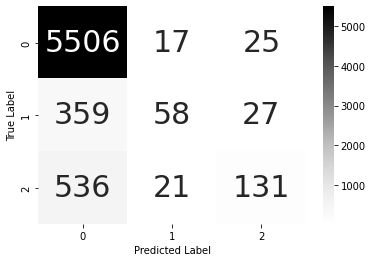

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmSVM, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Random Forest Classifier



In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier()
RF_clf.fit(X_train_encoded, y_train)


RandomForestClassifier()

In [ ]:
RF_y_pred = RF_clf.predict(X_test_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(y_test, RF_y_pred)))
print("Precision: ",str(precision_score(y_test, RF_y_pred, average='macro')))
print("Recall: " + str(recall_score(y_test, RF_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(y_test, RF_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(y_test, RF_y_pred, average='macro')))


cmRF = confusion_matrix(y_test, RF_y_pred)
crRF = classification_report(y_test, RF_y_pred)

Accuracy: 0.856437125748503
Precision:  0.6684319288971808
Recall: 0.5050242906090813
F1 - micro: 0.856437125748503
F1 - macro: 0.5490570107291394


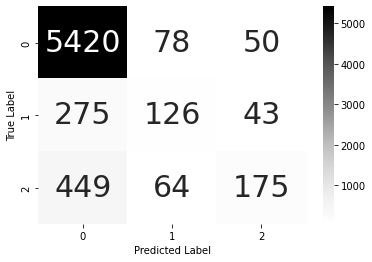

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmRF, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
## Test wrong case
i=0
for idx, text_input, prediction, label in zip(enumerate(X_test_encoded), X_test_encoded, RF_y_pred, y_test):
    if prediction != label:
        i+=1
        print("No.", idx[0], ', has been classified as', prediction, 'and should be', label) 
print(i)

No. 0 , has been classified as 2 and should be 0
No. 1 , has been classified as 0 and should be 1
No. 4 , has been classified as 0 and should be 1
No. 9 , has been classified as 1 and should be 0
No. 22 , has been classified as 0 and should be 2
No. 23 , has been classified as 0 and should be 2
No. 32 , has been classified as 0 and should be 1
No. 34 , has been classified as 0 and should be 1
No. 42 , has been classified as 2 and should be 0
No. 60 , has been classified as 0 and should be 1
No. 64 , has been classified as 0 and should be 1
No. 76 , has been classified as 0 and should be 2
No. 109 , has been classified as 1 and should be 2
No. 113 , has been classified as 0 and should be 2
No. 129 , has been classified as 2 and should be 0
No. 131 , has been classified as 0 and should be 2
No. 136 , has been classified as 1 and should be 0
No. 138 , has been classified as 1 and should be 0
No. 142 , has been classified as 0 and should be 2
No. 143 , has been classified as 0 and should b

In [ ]:
X_train[6554]

'xác'

##Not including stopwords

### Naive Bayes



In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB_nsw = MultinomialNB()
NB_nsw.fit(X_train_nsw_encoded, train_y)

MultinomialNB()

In [ ]:
NB_nsw_y_pred = NB_nsw.predict(X_test_nsw_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(test_y, NB_nsw_y_pred)))
print("Precision: ",str(precision_score(test_y, NB_nsw_y_pred, average='macro')))
print("Recall: " + str(recall_score(test_y, NB_nsw_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(test_y, NB_nsw_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(test_y, NB_nsw_y_pred, average='macro')))

cmNB_nsw = confusion_matrix(test_y, NB_nsw_y_pred)
crNB_nsw = classification_report(test_y, NB_nsw_y_pred)

Accuracy: 0.858682634730539
Precision:  0.6547662009113132
Recall: 0.5197514125181334
F1 - micro: 0.858682634730539
F1 - macro: 0.5440992734398563


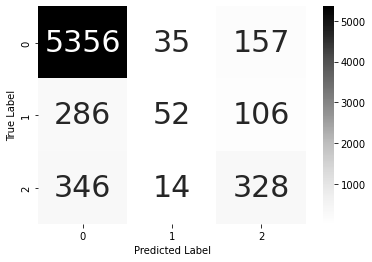

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmNB_nsw, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_nsw = LogisticRegression()
LR_nsw.fit(X_train_nsw_encoded, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
LR_nsw_y_pred=LR_nsw.predict(X_test_nsw_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(test_y, LR_nsw_y_pred)))
print("Precision: ",str(precision_score(test_y, LR_nsw_y_pred, average='macro')))
print("Recall: " + str(recall_score(test_y, LR_nsw_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(test_y, LR_nsw_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(test_y, LR_nsw_y_pred, average='macro')))


cmLR_nsw = confusion_matrix(test_y, LR_nsw_y_pred)
crLR_nsw = classification_report(test_y, LR_nsw_y_pred)

Accuracy: 0.8654191616766467
Precision:  0.6749487931024838
Recall: 0.550464165520293
F1 - micro: 0.8654191616766467
F1 - macro: 0.5904533046688788


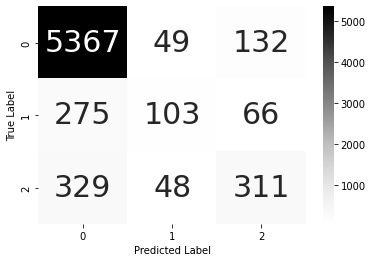

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmLR_nsw, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Decision Tree

In [ ]:
from sklearn import tree
DST_nsw = tree.DecisionTreeClassifier()
DST_nsw = DST_nsw.fit(X_train_nsw_encoded, train_y)

In [ ]:
DST_nsw_y_pred = DST_nsw.predict(X_test_nsw_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(test_y, DST_nsw_y_pred)))
print("Precision: ",str(precision_score(test_y, DST_nsw_y_pred, average='macro')))
print("Recall: " + str(recall_score(test_y, DST_nsw_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(test_y, DST_nsw_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(test_y, DST_nsw_y_pred, average='macro')))

cmDST_nsw = confusion_matrix(test_y, DST_nsw_y_pred)
crDST_nsw = classification_report(test_y, DST_nsw_y_pred)

Accuracy: 0.8333832335329341
Precision:  0.5724915626500633
Recall: 0.546092692346947
F1 - micro: 0.833383233532934
F1 - macro: 0.5564530673841427


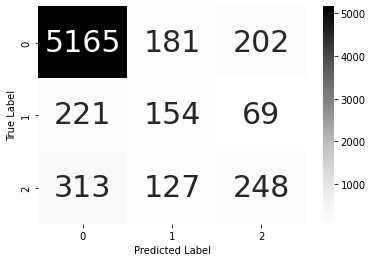

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmDST_nsw, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_nsw = RandomForestClassifier()
RF_nsw.fit(X_train_nsw_encoded, train_y)


RandomForestClassifier()

In [ ]:
RF_nsw_y_pred = RF_nsw.predict(X_test_nsw_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(test_y, RF_nsw_y_pred)))
print("Precision: ",str(precision_score(test_y, RF_nsw_y_pred, average='macro')))
print("Recall: " + str(recall_score(test_y, RF_nsw_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(test_y, RF_nsw_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(test_y, RF_nsw_y_pred, average='macro')))

cmRF_nsw = confusion_matrix(test_y, RF_nsw_y_pred)
crRF_nsw = classification_report(test_y, RF_nsw_y_pred)

Accuracy: 0.8529940119760479
Precision:  0.6380337406694169
Recall: 0.5282243121544107
F1 - micro: 0.8529940119760479
F1 - macro: 0.5639731798246119


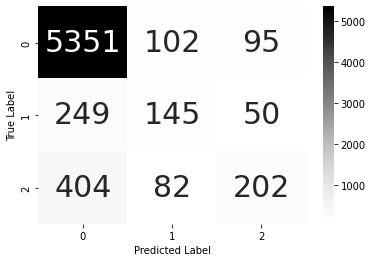

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmRF_nsw, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
## Test wrong case
i=0
for idx, text_input, prediction, label in zip(enumerate(X_test_nsw_encoded), X_test_nsw_encoded, RF_nsw_y_pred, y_test):
    if prediction != label:
        i+=1
        print("No.", idx[0], ', has been classified as', prediction, 'and should be', label) 
print(i)

No. 0 , has been classified as 2 and should be 0
No. 1 , has been classified as 0 and should be 1
No. 4 , has been classified as 0 and should be 1
No. 9 , has been classified as 1 and should be 0
No. 13 , has been classified as 2 and should be 0
No. 23 , has been classified as 0 and should be 2
No. 34 , has been classified as 0 and should be 1
No. 60 , has been classified as 0 and should be 1
No. 64 , has been classified as 0 and should be 1
No. 76 , has been classified as 0 and should be 2
No. 80 , has been classified as 0 and should be 2
No. 109 , has been classified as 1 and should be 2
No. 113 , has been classified as 1 and should be 2
No. 129 , has been classified as 2 and should be 0
No. 131 , has been classified as 0 and should be 2
No. 136 , has been classified as 1 and should be 0
No. 138 , has been classified as 1 and should be 0
No. 142 , has been classified as 0 and should be 2
No. 143 , has been classified as 0 and should be 2
No. 144 , has been classified as 0 and should 

In [ ]:
arr1=[]
for idx, text_input, prediction, label in zip(enumerate(X_test_encoded), X_test_encoded, RF_y_pred, y_test):
    if prediction != label:
        arr1.append(idx[0])

arr2=[]
for idx, text_input, prediction, label in zip(enumerate(X_test_nsw_encoded), X_test_nsw_encoded, RF_nsw_y_pred, y_test):
    if prediction != label:
        arr2.append(idx[0])


list(set(arr1) - set(arr2)) + list(set(arr2) - set(arr1))


[4099,
 2052,
 22,
 6678,
 32,
 1573,
 1062,
 5161,
 42,
 1080,
 4156,
 3648,
 1611,
 3659,
 5709,
 5203,
 4087,
 6233,
 2141,
 2142,
 6239,
 5216,
 5220,
 614,
 4710,
 616,
 3176,
 1639,
 5738,
 1646,
 1136,
 5235,
 1652,
 4213,
 3700,
 4733,
 3714,
 3715,
 2714,
 2725,
 3242,
 3756,
 4270,
 1198,
 1724,
 1725,
 5310,
 2752,
 196,
 5829,
 1225,
 5324,
 3283,
 1236,
 6357,
 4821,
 1749,
 216,
 1758,
 3297,
 5345,
 3812,
 3301,
 5863,
 5352,
 2288,
 758,
 5369,
 5885,
 2814,
 3840,
 2817,
 1290,
 5390,
 787,
 3349,
 3865,
 3355,
 2845,
 5923,
 4902,
 5929,
 309,
 1333,
 824,
 825,
 4410,
 5435,
 2876,
 2366,
 320,
 5954,
 6471,
 3916,
 6480,
 3413,
 865,
 4452,
 2415,
 5499,
 6012,
 3968,
 6533,
 5511,
 3982,
 2961,
 3991,
 6040,
 5531,
 4509,
 5535,
 5538,
 6564,
 4015,
 1456,
 1475,
 965,
 6598,
 3530,
 3024,
 979,
 2006,
 5080,
 1503,
 3044,
 4068,
 3558,
 3047,
 1517,
 4590,
 3575,
 504,
 5115,
 5116,
 6658,
 13,
 1040,
 6163,
 2582,
 535,
 5144,
 1563,
 6172,
 540,
 6174,
 2594,
 1

In [ ]:
X_test[5235]

'liếm ko từ cái gì cả cứt và lá xoan cũng liếm nốt'

In [ ]:
X_test[5530]

'thôi bớt ngựa ông đừng đi tùm_lum để khéo mắc bệnh rồi cách_li là dân việt_nam mừng lắm rồi'

In [ ]:
test_X[4933]

'giúp k đm'

### Support Vector Machine

In [ ]:
from sklearn import svm
SVM_nsw = svm.SVC(decision_function_shape='ovo')
SVM_nsw.fit(X_train_nsw_encoded, train_y) 

SVC(decision_function_shape='ovo')

In [ ]:
SVM_nsw_y_pred = SVM_nsw.predict(X_test_nsw_encoded)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
print("Accuracy: {}".format(accuracy_score(test_y, SVM_nsw_y_pred)))
print("Precision: ",str(precision_score(test_y, SVM_nsw_y_pred, average='macro')))
print("Recall: " + str(recall_score(test_y, SVM_nsw_y_pred, average='macro')))
print("F1 - micro: " + str(f1_score(test_y, SVM_nsw_y_pred, average='micro')))
print("F1 - macro: " + str(f1_score(test_y, SVM_nsw_y_pred, average='macro')))

cmSVM_nsw = confusion_matrix(test_y, SVM_nsw_y_pred)
crSVM_nsw = classification_report(test_y, SVM_nsw_y_pred)

Accuracy: 0.8538922155688623
Precision:  0.7068643739332637
Recall: 0.44568631251764496
F1 - micro: 0.8538922155688623
F1 - macro: 0.48813077866515026


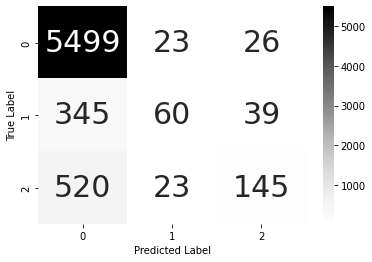

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.heatmap(cmSVM_nsw, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Demo

In [ ]:
REAL_LABEL = {
    0: "CLEAR (SẠCH)",
    1: "OFFENSIVE (XÚC PHẠM)",
    2: "HATE (THÙ GHÉT)"
}

In [ ]:
# demo random forest with stopwords
textS = input('Nhập bình luận: ')
textS_encoded = vectorizer.transform([textS])
label = RF_clf.predict(textS_encoded)

print("Nhãn của câu bình luận là: {}".format(REAL_LABEL[label[0]]))

Nhập bình luận: thần điêu đại bịp
Nhãn của câu bình luận là: CLEAR (SẠCH)
